# Super-Resolution with SRGAN

# Biweekly Report 5

## Jake Watts

Here I implement an SRGAN model based on the paper "Photo-Realistic Single Image Super-Resolution Using a Generative Adversarial Network". To train the model, I use the Flickr2K dataset, which contains 2,650 high-resolution images. For testing, I use the PIRM dataset, which contains pairs of low and high-resolution images. I define low-resolution images to be 32x32 and high-resolution images to be 128x128 and resize all training and testing images appropriately.

I first use adversarial training to generate photo-realistic images from the low-resolution images. I then continue to train the generator to see if the performance will continue to improve. The results from this SRGAN can also be used as a baseline to compare this model to other architectures designed for photo-realistic image generation.

Sources:

https://arxiv.org/abs/1609.04802

https://cvnote.ddlee.cc/2019/09/22/image-super-resolution-datasets

https://www.tensorflow.org/tutorials/generative/dcgan#save_checkpoints

https://www.tensorflow.org/tutorials/load_data/images#using_tfdata_for_finer_control

https://medium.com/analytics-vidhya/implementing-srresnet-srgan-super-resolution-with-tensorflow-89900d2ec9b2

## Data Pre-Processing

In [ ]:
import os
import cv2
import tqdm
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Unzipping Fickr2k data

In [ ]:
!unzip -qq drive/MyDrive/'Copy of Flickr2K.zip'

Listing and shuffling image file paths

In [ ]:
list_ds = tf.data.Dataset.list_files(str('/content/Flickr2K/*.png'), shuffle=False)
image_count = len(list_ds)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False, seed=12)

Checking to see that files are now shuffled

In [ ]:
for f in list_ds.take(5):
  print(f.numpy())

b'/content/Flickr2K/000963.png'
b'/content/Flickr2K/000812.png'
b'/content/Flickr2K/001700.png'
b'/content/Flickr2K/000628.png'
b'/content/Flickr2K/001596.png'


Splitting the Flickr data into training and validation

In [ ]:
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

The training set has 2,120 images, and the validation set has 530

In [ ]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

2120
530


`decode_img` decodes png files and resizes them based on the size parameter 

In [ ]:
def decode_img(img, size):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_png(img, channels=3)
  # Resize the image to the desired size
  img = tf.image.resize(img, [size, size])
  img = img/255
  return img

`process_path` takes the file path of the images as input and returns low and high-resolution versions of the images

In [ ]:
def process_path(file_path):
  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img, 128)
  lr = tf.image.resize(img, (32,32))
  return lr, img

Creating training dataset

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_data = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)

`bicubic_interpolate` expands input images to the specified size using bicubic interpolation

In [ ]:
def bicubic_interpolate(image, shape):
  img_resized=cv2.resize(image, shape, interpolation=cv2.INTER_CUBIC)
  return img_resized

Now we can look at the images from the training data. The goal is to train the SRGAN model so that it produces a high-resolution output given a low-resolution input. The images created using bicubic interpolation can be used as a benchmark for the model we train since it is a simpler algorithm for creating high-resolution images. As we can see below, images created by bicubic interpolation are smoother than the low-resolution image but are blurry. My goal in training the SRGAN is to create images that look more photo-realistic than the images created by bicubic interpolation.

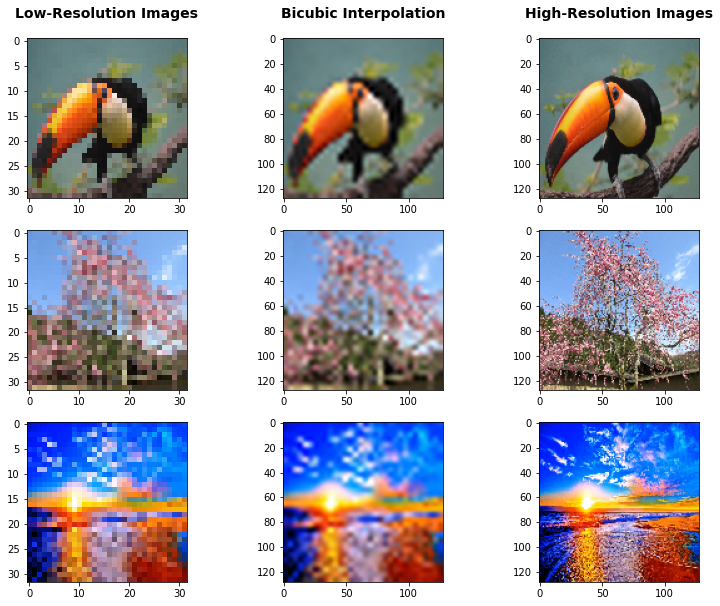

In [ ]:
figure = plt.figure(figsize=(13, 10))
i = 0
ex = 3
font = {'fontsize': 14,
 'fontweight' : 'bold',
 'verticalalignment': 'baseline',
 'horizontalalignment': 'center'}


for x in train_data.take(ex):
  i += 1
  plt.subplot(ex, 3, i)
  if i == 1:
    plt.title('Low-Resolution Images', pad=20, fontdict=font)
  plt.imshow(x[0].numpy())

  i += 1
  plt.subplot(ex, 3, i)
  bc = bicubic_interpolate(x[0].numpy(),(128,128))
  bc = np.clip(bc, 0, 1)
  if i == 2:
    plt.title('Bicubic Interpolation', pad=20, fontdict=font)
  plt.imshow(bc)

  i += 1
  plt.subplot(ex, 3, i)
  if i == 3:
    plt.title('High-Resolution Images', pad=20, fontdict=font)
  plt.imshow(x[1].numpy())

plt.show()

## SRGAN Architecture

### Generator

The generator network contains residual blocks with skip connections between each block. A block contains two convolution layers that have 64 filters, a kernel size of 3, and a stride of 1. Following the convolution layers, there is a batch normalization and a leaky ReLU layer. In this generator, there are five blocks that feed into two upsampling blocks to produce an output larger than the input.

In [ ]:
def residual_block_gen(ch=64,k_s=3,st=1):
  model=tf.keras.Sequential([
    tf.keras.layers.Conv2D(ch,k_s,strides=(st,st),padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Conv2D(ch,k_s,strides=(st,st),padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),
  ])
  return model

def Upsample_block(x, ch=256, k_s=3, st=1):
    x = tf.keras.layers.Conv2D(ch,k_s, strides=(st,st), padding='same')(x)
    x = tf.nn.depth_to_space(x, 2) # Subpixel pixelshuffler
    x = tf.keras.layers.LeakyReLU()(x)
    return x

input_lr=tf.keras.layers.Input(shape=(None,None,3))
input_conv=tf.keras.layers.Conv2D(64,9,padding='same')(input_lr)
input_conv=tf.keras.layers.LeakyReLU()(input_conv)

SRRes=input_conv
for x in range(5):
  res_output=residual_block_gen()(SRRes)
  SRRes=tf.keras.layers.Add()([SRRes,res_output])

SRRes=tf.keras.layers.Conv2D(64,9,padding='same')(SRRes)
SRRes=tf.keras.layers.BatchNormalization()(SRRes)

SRRes=tf.keras.layers.Add()([SRRes,input_conv])

SRRes=Upsample_block(SRRes)
SRRes=Upsample_block(SRRes)

output_sr=tf.keras.layers.Conv2D(3,9,activation='tanh',padding='same')(SRRes)

SRResnet=tf.keras.models.Model(input_lr,output_sr)

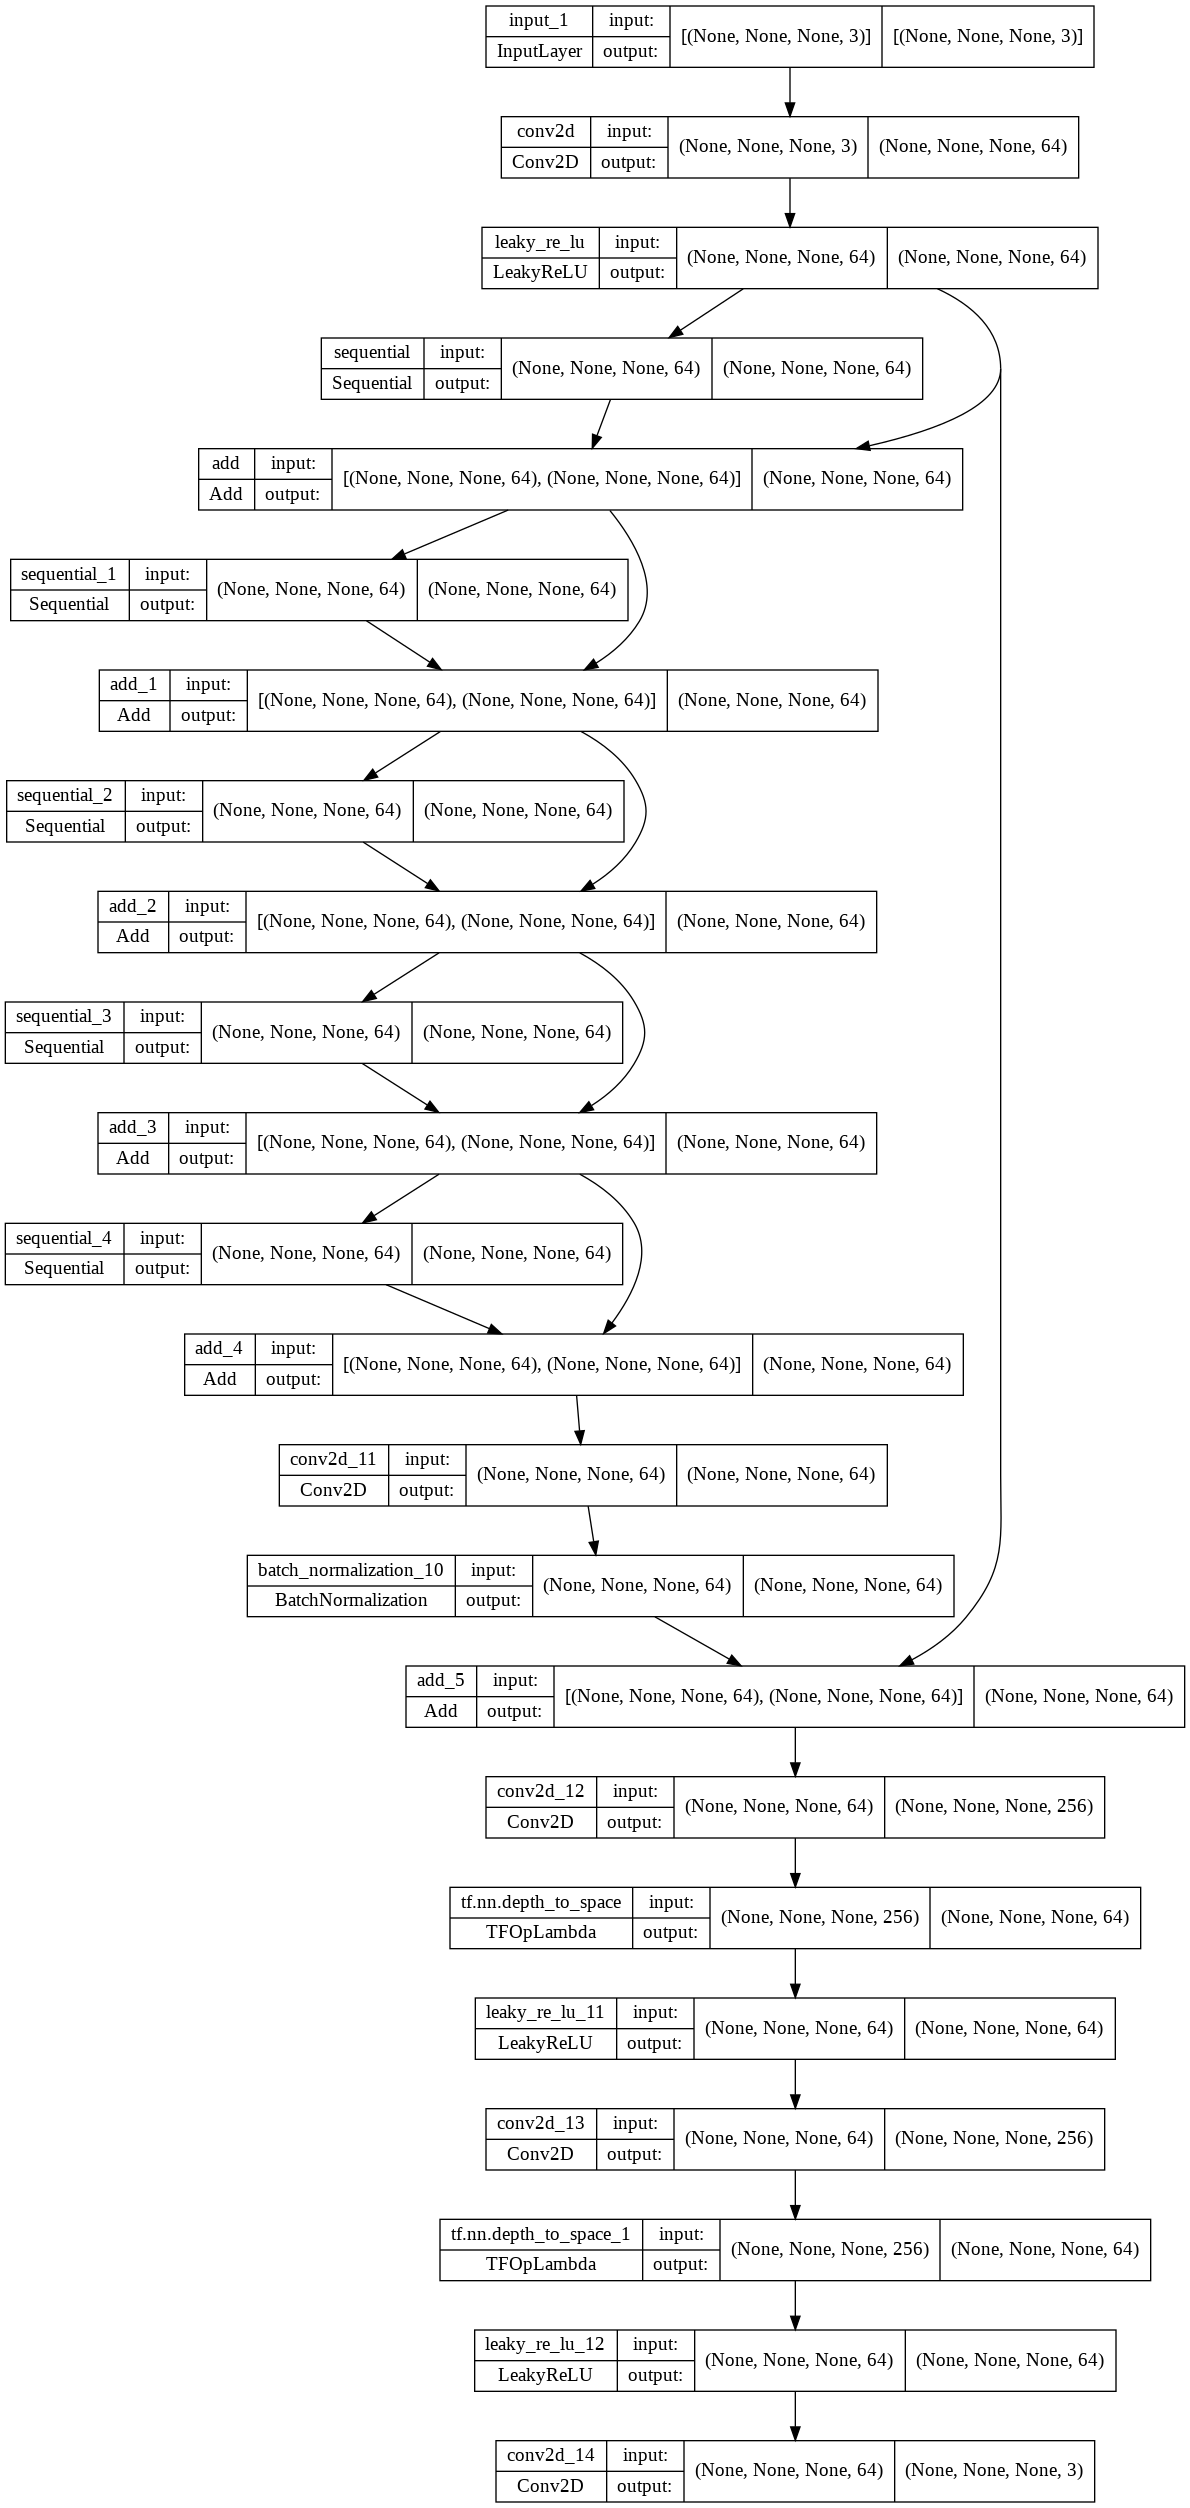

In [ ]:
tf.keras.utils.plot_model(SRResnet,show_shapes=True)

### Discriminator

The discriminator's purpose is to classify the generator's images as real or fake. It takes the output of the generator as its input. It contains seven convolutional layers followed by two dense layers. The output is binary to represent the two possible classifications of real and fake.

In [ ]:
def residual_block_disc(ch=64,k_s=3,st=1):
  model=tf.keras.Sequential([
    tf.keras.layers.Conv2D(ch,k_s,strides=(st,st),padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),
  ])
  return model

input_lr=tf.keras.layers.Input(shape=(128,128,3))
input_conv=tf.keras.layers.Conv2D(64,3,padding='same')(input_lr)
input_conv=tf.keras.layers.LeakyReLU()(input_conv)

channel_nums=[64,128,128,256,256,512,512]
stride_sizes=[2,1,2,1,2,1,2]

disc=input_conv
for x in range(7):
  disc=residual_block_disc(ch=channel_nums[x],st=stride_sizes[x])(disc)
  
disc=tf.keras.layers.Flatten()(disc)

disc=tf.keras.layers.Dense(1024)(disc)
disc=tf.keras.layers.LeakyReLU()(disc)

disc_output=tf.keras.layers.Dense(1,activation='sigmoid')(disc)

discriminator=tf.keras.models.Model(input_lr,disc_output)

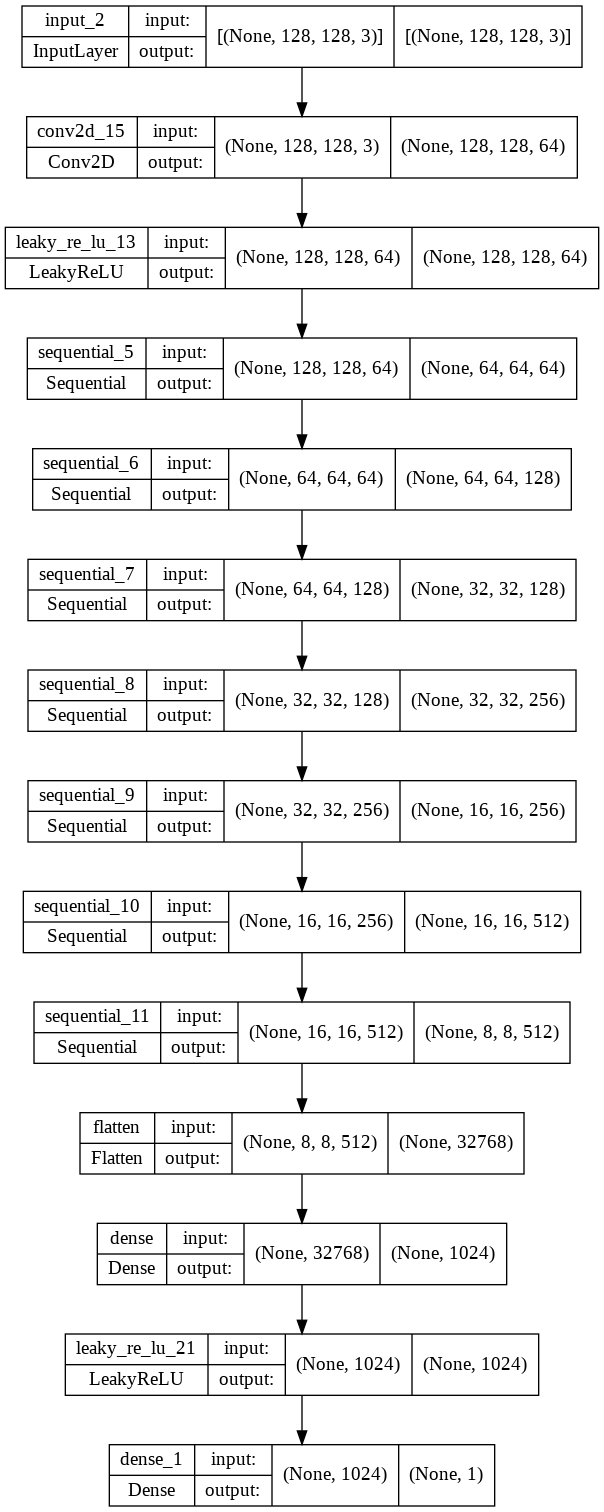

In [ ]:
tf.keras.utils.plot_model(discriminator,show_shapes=True)

### Loss

SRGAN uses both an adversarial loss and a content loss. The content loss is used to measure the perceptual similarity. A measure of perceptual similarity is included because MSE and PNSR do not do a good job of measuring perceptual differences. The perceptual loss is created by using high-level feature maps from a VGG network, allowing us to access perceptual similarity and hopefully create images that look more photo-realistic.

`PNSR` calculates the peak signal-to-noise ratio, which is a measure to identify the quality of the reconstructed image from the generator to the high-resolution image

`log10` is used in `PNSR` to compute $\log_{10}(x)$

`pixel_MSE` calculated the mean-square error between the real and generated image

In [ ]:
def PSNR(y_true,y_pred):
  mse=tf.reduce_mean( (y_true - y_pred) ** 2 )
  return 20 * log10(1 / (mse ** 0.5))

def log10(x):
  numerator = tf.math.log(x)
  denominator = tf.math.log(tf.constant(10, dtype=numerator.dtype))
  return numerator / denominator

def pixel_MSE(y_true,y_pred):
  return tf.reduce_mean( (y_true - y_pred) ** 2 )

Now I load VGG19, which is pre-trained on ImageNet data. Below we can see the layers of the model. We will input our high-resolution images into the model to obtain high-level feature maps.

In [ ]:
VGG19=tf.keras.applications.VGG19(weights='imagenet',include_top=False,input_shape=(128,128,3))
VGG19.layers

80150528/80134624 [==============================] - 1s 0us/step


`VGG_loss` loss calculates the perceptual loss between high and low-resolution images, with the depth of the VGG layers determined by `i_m` and `j_m`

`VGG_loss_intuitive` loss calculates the perceptual loss between fake and real images

In [ ]:
VGG_i,VGG_j= 2,2

def VGG_loss(y_hr,y_sr,i_m=2,j_m=2):
  i,j=0,0
  accumulated_loss=0.0
  for l in VGG19.layers:
    cl_name=l.__class__.__name__
    if cl_name=='Conv2D':
      j+=1
    if cl_name=='MaxPooling2D':
      i+=1
      j=0
    if i==i_m and j==j_m:
      break
    
    y_hr=l(y_hr)
    y_sr=l(y_sr)
    if cl_name=='Conv2D':
      accumulated_loss+=tf.reduce_mean((y_hr-y_sr)**2) * 0.006

  return accumulated_loss

def VGG_loss_intuitive(y_true,y_pred):
  accumulated_loss=0.0
  for l in VGG19.layers:
    y_true=l(y_true)
    y_pred=l(y_pred)
    accumulated_loss+=tf.reduce_mean((y_true-y_pred)**2) * 0.006
  return accumulated_loss

Here we define the discriminator and generator loss based on binary cross-entropy. The generator loss consists of content and adversarial loss, so this is only part of the total loss.

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()

def discriminator_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss
  
def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

## Training

Here we define hyperparameters for training. The learning rate for stochastic gradient descent is set to .0001. 

The adversarial ratio is the weight applied to the adversarial loss. 
In the paper "Photo-Realistic Single Image Super-Resolution Using a Generative Adversarial Network," they multiply the adversarial loss by .001 and the content loss by one. Then they add the two to get the generator's loss. I do the same here with `adv_ratio set` to .001.

I also choose to use SRGAN-VGG54, which utilizes deeper network layers than SRGAN-VGG22. Both models are discussed in the paper, but SRGAN-VGG54 was found to have better performance.

In [ ]:
generator_optimizer=tf.keras.optimizers.SGD(0.0001)
discriminator_optimizer=tf.keras.optimizers.SGD(0.0001)

adv_ratio=0.001
evaluate=['PSNR']

# SRGAN-VGG 5.4
loss_func,adv_learning = lambda y_hr,y_sr:VGG_loss(y_hr,y_sr,i_m=5,j_m=4),True

`train_step` updates the weights of the generator network. It also updates the weights of the discriminator network if `adv_learning` is set to true.


In [ ]:
@tf.function()
def train_step(data,loss_func=pixel_MSE,adv_learning=True,evaluate=['PSNR'],adv_ratio=0.001):
  logs={}
  gen_loss,disc_loss=0,0
  low_resolution,high_resolution=data
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    super_resolution = SRResnet(low_resolution, training=True)
    gen_loss=loss_func(high_resolution,super_resolution)
    logs['reconstruction']=gen_loss
    if adv_learning:
      real_output = discriminator(high_resolution, training=True)
      fake_output = discriminator(super_resolution, training=True)
      
      adv_loss_g = generator_loss(fake_output) * adv_ratio
      gen_loss += adv_loss_g
      
      disc_loss = discriminator_loss(real_output, fake_output)
      logs['adv_g']=adv_loss_g
      logs['adv_d']=disc_loss
  gradients_of_generator = gen_tape.gradient(gen_loss, SRResnet.trainable_variables)
  generator_optimizer.apply_gradients(zip(gradients_of_generator, SRResnet.trainable_variables))
  
  if adv_learning:
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
  
  for x in evaluate:
    if x=='PSNR':
      logs[x]=PSNR(high_resolution,super_resolution)
  return logs

Creating checkpoints to save training weights

In [ ]:
checkpoint_dir = '/content/drive/MyDrive/./training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=SRResnet,
                                 discriminator=discriminator)

Training the model for 50 epochs

In [ ]:
for x in range(50):
  train_dataset_mapped = train_ds.map(process_path,num_parallel_calls=tf.data.AUTOTUNE).batch(32)
  val_dataset_mapped = val_ds.map(process_path,num_parallel_calls=tf.data.AUTOTUNE).batch(32)
  for image_batch in tqdm.tqdm(train_dataset_mapped, position=0, leave=True):
    logs=train_step(image_batch,loss_func,adv_learning,evaluate,adv_ratio)
  checkpoint.save(file_prefix = checkpoint_prefix)
  for k in logs.keys():
    print(k,':',logs[k],end='  ')  
  print('Epoch:', x + 1, "Complete")

100%|██████████| 67/67 [02:37<00:00,  2.36s/it]


reconstruction : tf.Tensor(4.7619057, shape=(), dtype=float32)  Epoch: 0 Complete
adv_g : tf.Tensor(0.002580419, shape=(), dtype=float32)  Epoch: 0 Complete
adv_d : tf.Tensor(0.23553497, shape=(), dtype=float32)  Epoch: 0 Complete
PSNR : tf.Tensor(4.684813, shape=(), dtype=float32)  Epoch: 0 Complete


100%|██████████| 67/67 [02:44<00:00,  2.45s/it]


reconstruction : tf.Tensor(4.5290365, shape=(), dtype=float32)  Epoch: 1 Complete
adv_g : tf.Tensor(0.0034730684, shape=(), dtype=float32)  Epoch: 1 Complete
adv_d : tf.Tensor(0.0956126, shape=(), dtype=float32)  Epoch: 1 Complete
PSNR : tf.Tensor(4.8088236, shape=(), dtype=float32)  Epoch: 1 Complete


100%|██████████| 67/67 [02:33<00:00,  2.29s/it]


reconstruction : tf.Tensor(4.3528056, shape=(), dtype=float32)  Epoch: 2 Complete
adv_g : tf.Tensor(0.0039132196, shape=(), dtype=float32)  Epoch: 2 Complete
adv_d : tf.Tensor(0.059146117, shape=(), dtype=float32)  Epoch: 2 Complete
PSNR : tf.Tensor(4.9241977, shape=(), dtype=float32)  Epoch: 2 Complete


100%|██████████| 67/67 [02:29<00:00,  2.23s/it]


reconstruction : tf.Tensor(4.2020597, shape=(), dtype=float32)  Epoch: 3 Complete
adv_g : tf.Tensor(0.0041711493, shape=(), dtype=float32)  Epoch: 3 Complete
adv_d : tf.Tensor(0.043795273, shape=(), dtype=float32)  Epoch: 3 Complete
PSNR : tf.Tensor(5.0308094, shape=(), dtype=float32)  Epoch: 3 Complete


100%|██████████| 67/67 [03:06<00:00,  2.78s/it]


reconstruction : tf.Tensor(4.0803823, shape=(), dtype=float32)  Epoch: 4 Complete
adv_g : tf.Tensor(0.004361274, shape=(), dtype=float32)  Epoch: 4 Complete
adv_d : tf.Tensor(0.034674037, shape=(), dtype=float32)  Epoch: 4 Complete
PSNR : tf.Tensor(5.134779, shape=(), dtype=float32)  Epoch: 4 Complete


100%|██████████| 67/67 [03:21<00:00,  3.01s/it]


reconstruction : tf.Tensor(3.9867947, shape=(), dtype=float32)  Epoch: 5 Complete
adv_g : tf.Tensor(0.004542408, shape=(), dtype=float32)  Epoch: 5 Complete
adv_d : tf.Tensor(0.027961556, shape=(), dtype=float32)  Epoch: 5 Complete
PSNR : tf.Tensor(5.2496266, shape=(), dtype=float32)  Epoch: 5 Complete


100%|██████████| 67/67 [02:29<00:00,  2.23s/it]


reconstruction : tf.Tensor(3.9127812, shape=(), dtype=float32)  Epoch: 6 Complete
adv_g : tf.Tensor(0.0047459197, shape=(), dtype=float32)  Epoch: 6 Complete
adv_d : tf.Tensor(0.02287994, shape=(), dtype=float32)  Epoch: 6 Complete
PSNR : tf.Tensor(5.368719, shape=(), dtype=float32)  Epoch: 6 Complete


100%|██████████| 67/67 [03:21<00:00,  3.01s/it]


reconstruction : tf.Tensor(3.8518457, shape=(), dtype=float32)  Epoch: 7 Complete
adv_g : tf.Tensor(0.0049320287, shape=(), dtype=float32)  Epoch: 7 Complete
adv_d : tf.Tensor(0.019130204, shape=(), dtype=float32)  Epoch: 7 Complete
PSNR : tf.Tensor(5.487311, shape=(), dtype=float32)  Epoch: 7 Complete


100%|██████████| 67/67 [02:57<00:00,  2.64s/it]


reconstruction : tf.Tensor(3.7991734, shape=(), dtype=float32)  Epoch: 8 Complete
adv_g : tf.Tensor(0.0050952933, shape=(), dtype=float32)  Epoch: 8 Complete
adv_d : tf.Tensor(0.016441233, shape=(), dtype=float32)  Epoch: 8 Complete
PSNR : tf.Tensor(5.6040306, shape=(), dtype=float32)  Epoch: 8 Complete


100%|██████████| 67/67 [02:24<00:00,  2.16s/it]


reconstruction : tf.Tensor(3.7523031, shape=(), dtype=float32)  Epoch: 9 Complete
adv_g : tf.Tensor(0.0052408334, shape=(), dtype=float32)  Epoch: 9 Complete
adv_d : tf.Tensor(0.01420673, shape=(), dtype=float32)  Epoch: 9 Complete
PSNR : tf.Tensor(5.7177134, shape=(), dtype=float32)  Epoch: 9 Complete


100%|██████████| 67/67 [02:26<00:00,  2.18s/it]


reconstruction : tf.Tensor(3.7096713, shape=(), dtype=float32)  Epoch: 10 Complete
adv_g : tf.Tensor(0.0053647766, shape=(), dtype=float32)  Epoch: 10 Complete
adv_d : tf.Tensor(0.012391712, shape=(), dtype=float32)  Epoch: 10 Complete
PSNR : tf.Tensor(5.826987, shape=(), dtype=float32)  Epoch: 10 Complete


100%|██████████| 67/67 [02:27<00:00,  2.19s/it]


reconstruction : tf.Tensor(3.6706119, shape=(), dtype=float32)  Epoch: 11 Complete
adv_g : tf.Tensor(0.0054573943, shape=(), dtype=float32)  Epoch: 11 Complete
adv_d : tf.Tensor(0.010935759, shape=(), dtype=float32)  Epoch: 11 Complete
PSNR : tf.Tensor(5.931639, shape=(), dtype=float32)  Epoch: 11 Complete


100%|██████████| 67/67 [03:21<00:00,  3.01s/it]


reconstruction : tf.Tensor(3.6348205, shape=(), dtype=float32)  Epoch: 12 Complete
adv_g : tf.Tensor(0.005537878, shape=(), dtype=float32)  Epoch: 12 Complete
adv_d : tf.Tensor(0.009827724, shape=(), dtype=float32)  Epoch: 12 Complete
PSNR : tf.Tensor(6.031427, shape=(), dtype=float32)  Epoch: 12 Complete


100%|██████████| 67/67 [03:21<00:00,  3.01s/it]


reconstruction : tf.Tensor(3.6008654, shape=(), dtype=float32)  Epoch: 13 Complete
adv_g : tf.Tensor(0.005606078, shape=(), dtype=float32)  Epoch: 13 Complete
adv_d : tf.Tensor(0.008972098, shape=(), dtype=float32)  Epoch: 13 Complete
PSNR : tf.Tensor(6.126408, shape=(), dtype=float32)  Epoch: 13 Complete


100%|██████████| 67/67 [02:57<00:00,  2.65s/it]


reconstruction : tf.Tensor(3.5684183, shape=(), dtype=float32)  Epoch: 14 Complete
adv_g : tf.Tensor(0.005668476, shape=(), dtype=float32)  Epoch: 14 Complete
adv_d : tf.Tensor(0.008263617, shape=(), dtype=float32)  Epoch: 14 Complete
PSNR : tf.Tensor(6.216845, shape=(), dtype=float32)  Epoch: 14 Complete


100%|██████████| 67/67 [03:21<00:00,  3.01s/it]


reconstruction : tf.Tensor(3.537483, shape=(), dtype=float32)  Epoch: 15 Complete
adv_g : tf.Tensor(0.0057402737, shape=(), dtype=float32)  Epoch: 15 Complete
adv_d : tf.Tensor(0.007597793, shape=(), dtype=float32)  Epoch: 15 Complete
PSNR : tf.Tensor(6.3034563, shape=(), dtype=float32)  Epoch: 15 Complete


100%|██████████| 67/67 [03:21<00:00,  3.01s/it]


reconstruction : tf.Tensor(3.5078623, shape=(), dtype=float32)  Epoch: 16 Complete
adv_g : tf.Tensor(0.0058088065, shape=(), dtype=float32)  Epoch: 16 Complete
adv_d : tf.Tensor(0.007007165, shape=(), dtype=float32)  Epoch: 16 Complete
PSNR : tf.Tensor(6.386268, shape=(), dtype=float32)  Epoch: 16 Complete


100%|██████████| 67/67 [02:24<00:00,  2.15s/it]


reconstruction : tf.Tensor(3.4793916, shape=(), dtype=float32)  Epoch: 17 Complete
adv_g : tf.Tensor(0.0058728885, shape=(), dtype=float32)  Epoch: 17 Complete
adv_d : tf.Tensor(0.0065075946, shape=(), dtype=float32)  Epoch: 17 Complete
PSNR : tf.Tensor(6.465678, shape=(), dtype=float32)  Epoch: 17 Complete


100%|██████████| 67/67 [02:23<00:00,  2.15s/it]


reconstruction : tf.Tensor(3.4517217, shape=(), dtype=float32)  Epoch: 18 Complete
adv_g : tf.Tensor(0.005929227, shape=(), dtype=float32)  Epoch: 18 Complete
adv_d : tf.Tensor(0.0060948455, shape=(), dtype=float32)  Epoch: 18 Complete
PSNR : tf.Tensor(6.5421233, shape=(), dtype=float32)  Epoch: 18 Complete


100%|██████████| 67/67 [02:34<00:00,  2.31s/it]


reconstruction : tf.Tensor(3.425093, shape=(), dtype=float32)  Epoch: 19 Complete
adv_g : tf.Tensor(0.005986865, shape=(), dtype=float32)  Epoch: 19 Complete
adv_d : tf.Tensor(0.005687695, shape=(), dtype=float32)  Epoch: 19 Complete
PSNR : tf.Tensor(6.61639, shape=(), dtype=float32)  Epoch: 19 Complete


100%|██████████| 67/67 [02:24<00:00,  2.16s/it]


reconstruction : tf.Tensor(3.3992746, shape=(), dtype=float32)  Epoch: 20 Complete
adv_g : tf.Tensor(0.006044197, shape=(), dtype=float32)  Epoch: 20 Complete
adv_d : tf.Tensor(0.005289836, shape=(), dtype=float32)  Epoch: 20 Complete
PSNR : tf.Tensor(6.6882467, shape=(), dtype=float32)  Epoch: 20 Complete


100%|██████████| 67/67 [02:25<00:00,  2.17s/it]


reconstruction : tf.Tensor(3.3740063, shape=(), dtype=float32)  Epoch: 21 Complete
adv_g : tf.Tensor(0.0060900673, shape=(), dtype=float32)  Epoch: 21 Complete
adv_d : tf.Tensor(0.00495595, shape=(), dtype=float32)  Epoch: 21 Complete
PSNR : tf.Tensor(6.7578278, shape=(), dtype=float32)  Epoch: 21 Complete


100%|██████████| 67/67 [02:25<00:00,  2.17s/it]


reconstruction : tf.Tensor(3.3494143, shape=(), dtype=float32)  Epoch: 22 Complete
adv_g : tf.Tensor(0.0061325897, shape=(), dtype=float32)  Epoch: 22 Complete
adv_d : tf.Tensor(0.004685375, shape=(), dtype=float32)  Epoch: 22 Complete
PSNR : tf.Tensor(6.825698, shape=(), dtype=float32)  Epoch: 22 Complete


100%|██████████| 67/67 [03:21<00:00,  3.01s/it]


reconstruction : tf.Tensor(3.3253145, shape=(), dtype=float32)  Epoch: 23 Complete
adv_g : tf.Tensor(0.006170369, shape=(), dtype=float32)  Epoch: 23 Complete
adv_d : tf.Tensor(0.0044696336, shape=(), dtype=float32)  Epoch: 23 Complete
PSNR : tf.Tensor(6.8919616, shape=(), dtype=float32)  Epoch: 23 Complete


100%|██████████| 67/67 [03:21<00:00,  3.01s/it]


reconstruction : tf.Tensor(3.301826, shape=(), dtype=float32)  Epoch: 24 Complete
adv_g : tf.Tensor(0.0061920322, shape=(), dtype=float32)  Epoch: 24 Complete
adv_d : tf.Tensor(0.0043012872, shape=(), dtype=float32)  Epoch: 24 Complete
PSNR : tf.Tensor(6.956484, shape=(), dtype=float32)  Epoch: 24 Complete


100%|██████████| 67/67 [03:21<00:00,  3.01s/it]


reconstruction : tf.Tensor(3.2790432, shape=(), dtype=float32)  Epoch: 25 Complete
adv_g : tf.Tensor(0.0062032216, shape=(), dtype=float32)  Epoch: 25 Complete
adv_d : tf.Tensor(0.00416567, shape=(), dtype=float32)  Epoch: 25 Complete
PSNR : tf.Tensor(7.0195374, shape=(), dtype=float32)  Epoch: 25 Complete


100%|██████████| 67/67 [02:25<00:00,  2.17s/it]


reconstruction : tf.Tensor(3.2570128, shape=(), dtype=float32)  Epoch: 26 Complete
adv_g : tf.Tensor(0.006214896, shape=(), dtype=float32)  Epoch: 26 Complete
adv_d : tf.Tensor(0.0040302915, shape=(), dtype=float32)  Epoch: 26 Complete
PSNR : tf.Tensor(7.081041, shape=(), dtype=float32)  Epoch: 26 Complete


100%|██████████| 67/67 [02:24<00:00,  2.16s/it]


reconstruction : tf.Tensor(3.2355523, shape=(), dtype=float32)  Epoch: 27 Complete
adv_g : tf.Tensor(0.0062248735, shape=(), dtype=float32)  Epoch: 27 Complete
adv_d : tf.Tensor(0.003918877, shape=(), dtype=float32)  Epoch: 27 Complete
PSNR : tf.Tensor(7.1410584, shape=(), dtype=float32)  Epoch: 27 Complete


100%|██████████| 67/67 [03:21<00:00,  3.01s/it]


reconstruction : tf.Tensor(3.214602, shape=(), dtype=float32)  Epoch: 28 Complete
adv_g : tf.Tensor(0.0062337923, shape=(), dtype=float32)  Epoch: 28 Complete
adv_d : tf.Tensor(0.0038275868, shape=(), dtype=float32)  Epoch: 28 Complete
PSNR : tf.Tensor(7.200218, shape=(), dtype=float32)  Epoch: 28 Complete


100%|██████████| 67/67 [03:21<00:00,  3.01s/it]


reconstruction : tf.Tensor(3.1939454, shape=(), dtype=float32)  Epoch: 29 Complete
adv_g : tf.Tensor(0.0062429984, shape=(), dtype=float32)  Epoch: 29 Complete
adv_d : tf.Tensor(0.003735948, shape=(), dtype=float32)  Epoch: 29 Complete
PSNR : tf.Tensor(7.2579937, shape=(), dtype=float32)  Epoch: 29 Complete


100%|██████████| 67/67 [02:24<00:00,  2.15s/it]


reconstruction : tf.Tensor(3.173732, shape=(), dtype=float32)  Epoch: 30 Complete
adv_g : tf.Tensor(0.006253662, shape=(), dtype=float32)  Epoch: 30 Complete
adv_d : tf.Tensor(0.0036498355, shape=(), dtype=float32)  Epoch: 30 Complete
PSNR : tf.Tensor(7.314785, shape=(), dtype=float32)  Epoch: 30 Complete


100%|██████████| 67/67 [02:24<00:00,  2.16s/it]


reconstruction : tf.Tensor(3.154131, shape=(), dtype=float32)  Epoch: 31 Complete
adv_g : tf.Tensor(0.0062651294, shape=(), dtype=float32)  Epoch: 31 Complete
adv_d : tf.Tensor(0.0035701618, shape=(), dtype=float32)  Epoch: 31 Complete
PSNR : tf.Tensor(7.370524, shape=(), dtype=float32)  Epoch: 31 Complete


100%|██████████| 67/67 [03:21<00:00,  3.01s/it]


reconstruction : tf.Tensor(3.135106, shape=(), dtype=float32)  Epoch: 32 Complete
adv_g : tf.Tensor(0.0062703234, shape=(), dtype=float32)  Epoch: 32 Complete
adv_d : tf.Tensor(0.0035078144, shape=(), dtype=float32)  Epoch: 32 Complete
PSNR : tf.Tensor(7.4254837, shape=(), dtype=float32)  Epoch: 32 Complete


100%|██████████| 67/67 [03:21<00:00,  3.01s/it]


reconstruction : tf.Tensor(3.116631, shape=(), dtype=float32)  Epoch: 33 Complete
adv_g : tf.Tensor(0.0062708943, shape=(), dtype=float32)  Epoch: 33 Complete
adv_d : tf.Tensor(0.003452654, shape=(), dtype=float32)  Epoch: 33 Complete
PSNR : tf.Tensor(7.4794984, shape=(), dtype=float32)  Epoch: 33 Complete


100%|██████████| 67/67 [02:24<00:00,  2.15s/it]


reconstruction : tf.Tensor(3.0986078, shape=(), dtype=float32)  Epoch: 34 Complete
adv_g : tf.Tensor(0.0062752226, shape=(), dtype=float32)  Epoch: 34 Complete
adv_d : tf.Tensor(0.0033852411, shape=(), dtype=float32)  Epoch: 34 Complete
PSNR : tf.Tensor(7.532522, shape=(), dtype=float32)  Epoch: 34 Complete


100%|██████████| 67/67 [02:24<00:00,  2.16s/it]


reconstruction : tf.Tensor(3.0810056, shape=(), dtype=float32)  Epoch: 35 Complete
adv_g : tf.Tensor(0.0062833936, shape=(), dtype=float32)  Epoch: 35 Complete
adv_d : tf.Tensor(0.0033115456, shape=(), dtype=float32)  Epoch: 35 Complete
PSNR : tf.Tensor(7.584741, shape=(), dtype=float32)  Epoch: 35 Complete


100%|██████████| 67/67 [03:21<00:00,  3.01s/it]


reconstruction : tf.Tensor(3.0637712, shape=(), dtype=float32)  Epoch: 36 Complete
adv_g : tf.Tensor(0.006289755, shape=(), dtype=float32)  Epoch: 36 Complete
adv_d : tf.Tensor(0.003245179, shape=(), dtype=float32)  Epoch: 36 Complete
PSNR : tf.Tensor(7.6362505, shape=(), dtype=float32)  Epoch: 36 Complete


100%|██████████| 67/67 [02:24<00:00,  2.16s/it]


reconstruction : tf.Tensor(3.046867, shape=(), dtype=float32)  Epoch: 37 Complete
adv_g : tf.Tensor(0.006291637, shape=(), dtype=float32)  Epoch: 37 Complete
adv_d : tf.Tensor(0.0031897663, shape=(), dtype=float32)  Epoch: 37 Complete
PSNR : tf.Tensor(7.687304, shape=(), dtype=float32)  Epoch: 37 Complete


100%|██████████| 67/67 [02:24<00:00,  2.16s/it]


reconstruction : tf.Tensor(3.0302982, shape=(), dtype=float32)  Epoch: 38 Complete
adv_g : tf.Tensor(0.006292514, shape=(), dtype=float32)  Epoch: 38 Complete
adv_d : tf.Tensor(0.0031396998, shape=(), dtype=float32)  Epoch: 38 Complete
PSNR : tf.Tensor(7.738356, shape=(), dtype=float32)  Epoch: 38 Complete


100%|██████████| 67/67 [02:24<00:00,  2.16s/it]


reconstruction : tf.Tensor(3.0140185, shape=(), dtype=float32)  Epoch: 39 Complete
adv_g : tf.Tensor(0.0062971315, shape=(), dtype=float32)  Epoch: 39 Complete
adv_d : tf.Tensor(0.0030784588, shape=(), dtype=float32)  Epoch: 39 Complete
PSNR : tf.Tensor(7.7889996, shape=(), dtype=float32)  Epoch: 39 Complete


100%|██████████| 67/67 [02:25<00:00,  2.17s/it]


reconstruction : tf.Tensor(2.9978766, shape=(), dtype=float32)  Epoch: 40 Complete
adv_g : tf.Tensor(0.0063001933, shape=(), dtype=float32)  Epoch: 40 Complete
adv_d : tf.Tensor(0.0030200412, shape=(), dtype=float32)  Epoch: 40 Complete
PSNR : tf.Tensor(7.839568, shape=(), dtype=float32)  Epoch: 40 Complete


100%|██████████| 67/67 [02:25<00:00,  2.17s/it]


reconstruction : tf.Tensor(2.981956, shape=(), dtype=float32)  Epoch: 41 Complete
adv_g : tf.Tensor(0.0063024466, shape=(), dtype=float32)  Epoch: 41 Complete
adv_d : tf.Tensor(0.0029673344, shape=(), dtype=float32)  Epoch: 41 Complete
PSNR : tf.Tensor(7.8900986, shape=(), dtype=float32)  Epoch: 41 Complete


100%|██████████| 67/67 [02:24<00:00,  2.16s/it]


reconstruction : tf.Tensor(2.9660363, shape=(), dtype=float32)  Epoch: 42 Complete
adv_g : tf.Tensor(0.0063054487, shape=(), dtype=float32)  Epoch: 42 Complete
adv_d : tf.Tensor(0.002919857, shape=(), dtype=float32)  Epoch: 42 Complete
PSNR : tf.Tensor(7.9404573, shape=(), dtype=float32)  Epoch: 42 Complete


100%|██████████| 67/67 [03:21<00:00,  3.01s/it]


reconstruction : tf.Tensor(2.950362, shape=(), dtype=float32)  Epoch: 43 Complete
adv_g : tf.Tensor(0.0063083027, shape=(), dtype=float32)  Epoch: 43 Complete
adv_d : tf.Tensor(0.0028786839, shape=(), dtype=float32)  Epoch: 43 Complete
PSNR : tf.Tensor(7.99079, shape=(), dtype=float32)  Epoch: 43 Complete


100%|██████████| 67/67 [03:21<00:00,  3.01s/it]


reconstruction : tf.Tensor(2.934792, shape=(), dtype=float32)  Epoch: 44 Complete
adv_g : tf.Tensor(0.006311947, shape=(), dtype=float32)  Epoch: 44 Complete
adv_d : tf.Tensor(0.0028348404, shape=(), dtype=float32)  Epoch: 44 Complete
PSNR : tf.Tensor(8.040694, shape=(), dtype=float32)  Epoch: 44 Complete


100%|██████████| 67/67 [02:32<00:00,  2.27s/it]


reconstruction : tf.Tensor(2.9193683, shape=(), dtype=float32)  Epoch: 45 Complete
adv_g : tf.Tensor(0.0063171643, shape=(), dtype=float32)  Epoch: 45 Complete
adv_d : tf.Tensor(0.002788619, shape=(), dtype=float32)  Epoch: 45 Complete
PSNR : tf.Tensor(8.090516, shape=(), dtype=float32)  Epoch: 45 Complete


100%|██████████| 67/67 [02:32<00:00,  2.28s/it]


reconstruction : tf.Tensor(2.9038134, shape=(), dtype=float32)  Epoch: 46 Complete
adv_g : tf.Tensor(0.006321872, shape=(), dtype=float32)  Epoch: 46 Complete
adv_d : tf.Tensor(0.0027500903, shape=(), dtype=float32)  Epoch: 46 Complete
PSNR : tf.Tensor(8.140046, shape=(), dtype=float32)  Epoch: 46 Complete


100%|██████████| 67/67 [03:21<00:00,  3.01s/it]


reconstruction : tf.Tensor(2.8883693, shape=(), dtype=float32)  Epoch: 47 Complete
adv_g : tf.Tensor(0.006327158, shape=(), dtype=float32)  Epoch: 47 Complete
adv_d : tf.Tensor(0.002715527, shape=(), dtype=float32)  Epoch: 47 Complete
PSNR : tf.Tensor(8.189481, shape=(), dtype=float32)  Epoch: 47 Complete


100%|██████████| 67/67 [03:21<00:00,  3.01s/it]


reconstruction : tf.Tensor(2.8729467, shape=(), dtype=float32)  Epoch: 48 Complete
adv_g : tf.Tensor(0.006330611, shape=(), dtype=float32)  Epoch: 48 Complete
adv_d : tf.Tensor(0.0026888382, shape=(), dtype=float32)  Epoch: 48 Complete
PSNR : tf.Tensor(8.238735, shape=(), dtype=float32)  Epoch: 48 Complete


100%|██████████| 67/67 [02:48<00:00,  2.51s/it]


reconstruction : tf.Tensor(2.8574655, shape=(), dtype=float32)  Epoch: 49 Complete
adv_g : tf.Tensor(0.006331279, shape=(), dtype=float32)  Epoch: 49 Complete
adv_d : tf.Tensor(0.0026705978, shape=(), dtype=float32)  Epoch: 49 Complete
PSNR : tf.Tensor(8.287898, shape=(), dtype=float32)  Epoch: 49 Complete


After 50 epochs of adversarial training we can see that the discriminators loss decreased from .23 after the first epoch to .0026 after the 50th epoch. Meanwhile the generator's loss increased from .0025 to .0063.

## Evaluation

Now that we have trained the model, we can evaluate the performance on the test set.

Restoring the latest checkpoint from training

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Unzipping the PIRM test data

In [ ]:
!unzip -qq /content/test_set.zip

Listing and shuffling low and high-resolution images

In [ ]:
test_lr = tf.data.Dataset.list_files(str('/content/test_set/LR/*png'), shuffle=False)
image_count = len(test_lr)
test_lr = test_lr.shuffle(image_count, reshuffle_each_iteration=False, seed=3)

test_hr = tf.data.Dataset.list_files(str('/content/test_set/HR/*png'), shuffle=False)
test_hr = test_hr.shuffle(image_count, reshuffle_each_iteration=False, seed=3)

`process_test_lr` is used to process and resize low-resolution images

`process_test_hr` is used to process and resize high-resolution images

In [ ]:
def process_test_lr(file_path):
  f = tf.io.read_file(file_path)
  img = decode_img(f, 32)
  return img

def process_test_hr(file_path):
  f = tf.io.read_file(file_path)
  img = decode_img(f, 128)
  return img

Creating datasets for the low and high-resolution test data

In [ ]:
test_lr= test_lr.map(process_test_lr, num_parallel_calls=AUTOTUNE)
test_hr= test_hr.map(process_test_hr, num_parallel_calls=AUTOTUNE)

`plot_predictions` plots the low and high-resolution images in the test set along with the bicubic interpolations and the model's prediction based on the low-resolution images

In [ ]:
def plot_predictions(examples, clip):
  figure = plt.figure(figsize=(13, 10))
  i = 0
  ex = examples
  font = {'fontsize': 14, 
          'fontweight' : 'bold',
          'verticalalignment': 'baseline',
          'horizontalalignment': 'center'}

  for x, y in zip(test_lr.take(ex), test_hr.take(ex)):
    i += 1
    plt.subplot(ex, 4, i)
    if i == 1:
      plt.title('Low-Resolution Images', pad=20, fontdict=font)
    plt.imshow(x.numpy())

    i += 1
    plt.subplot(ex, 4, i)
    bc = bicubic_interpolate(x.numpy(),(128,128))
    bc = np.clip(bc, 0, 1)
    if i == 2:
      plt.title('Bicubic Interpolation', pad=20, fontdict=font)
    plt.imshow(bc)

    i += 1
    plt.subplot(ex, 4, i)
    pred = SRResnet.predict(tf.reshape(x, [1, 32, 32, 3]))
    if i == 3:
      plt.title('Model Prediction', pad=20, fontdict=font)
    if clip is False:
      min = tf.experimental.numpy.amin(pred)
      max = tf.experimental.numpy.amax(pred)
      pred = (pred - min)/(max - min)
      plt.imshow(pred[0].numpy())
    else:
      plt.imshow(np.clip(pred[0], 0, 1))

    i += 1
    plt.subplot(ex, 4, i)
    if i == 4:
      plt.title('High-Resolution Images', pad=20, fontdict=font)
    plt.imshow(y.numpy())

  plt.show()

Below we can see that the model's prediction does not out-perform bicubic interpolation. The shapes in the predicted images somewhat resemble the real image, but the colors are off. I don't think any human would have trouble identifying the real high-resolution image. The predicted images look like high-resolution images with a bunch of random noise added.

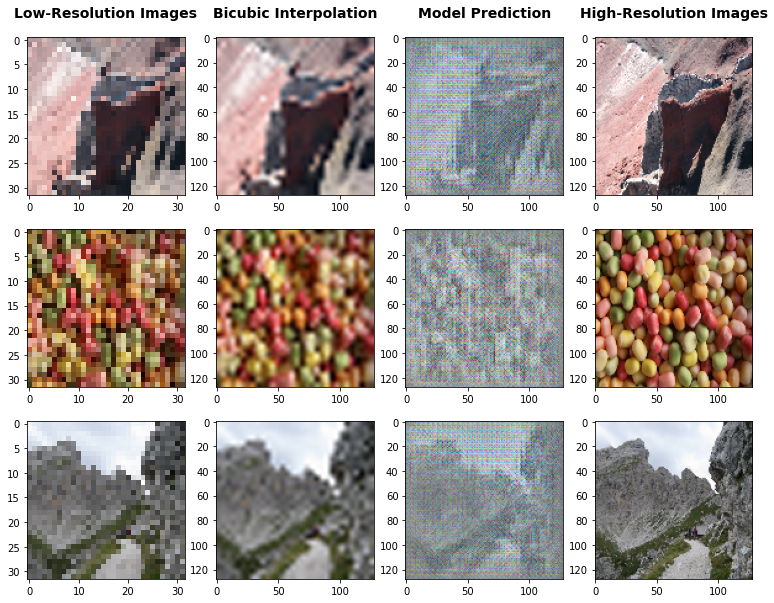

In [ ]:
plot_predictions(3, clip=False)

`plot_epochs` plots model predictions by epoch

In [ ]:
file_loc = '/content/drive/MyDrive/./training_checkpoints/ckpt-{}'

def plot_epochs(examples, clip):
  figure = plt.figure(figsize=(13, 10))
  j = 0
  ex = examples
  font = {'fontsize': 14, 
          'fontweight' : 'bold',
          'verticalalignment': 'baseline',
          'horizontalalignment': 'center'}

  for x, y in zip(test_lr.take(ex), test_hr.take(ex)):
    for i in range(5):
      file_chkpt = file_loc.format(i*10 + 10)
      checkpoint.restore(file_chkpt)
      j += 1
      plt.subplot(ex, 5, j)
      pred = SRResnet.predict(tf.reshape(x, [1, 32, 32, 3]))
      if j in (1, 2, 3, 4, 5):
        plt.title('Epoch {}'.format(j*10), pad=20, fontdict=font)
      if clip is False:
        min = tf.experimental.numpy.amin(pred)
        max = tf.experimental.numpy.amax(pred)
        pred = (pred - min)/(max - min)
        plt.imshow(pred[0].numpy())
      else:
        plt.imshow(np.clip(pred[0], 0, 1))

  plt.show()

Here I wanted to take a look at generated images using training checkpoints from previous epochs. I was curious to see if the predictions were better in any previous epochs, but it appears that the images consistently improved over the epochs, although not enough to be photo-realistic.

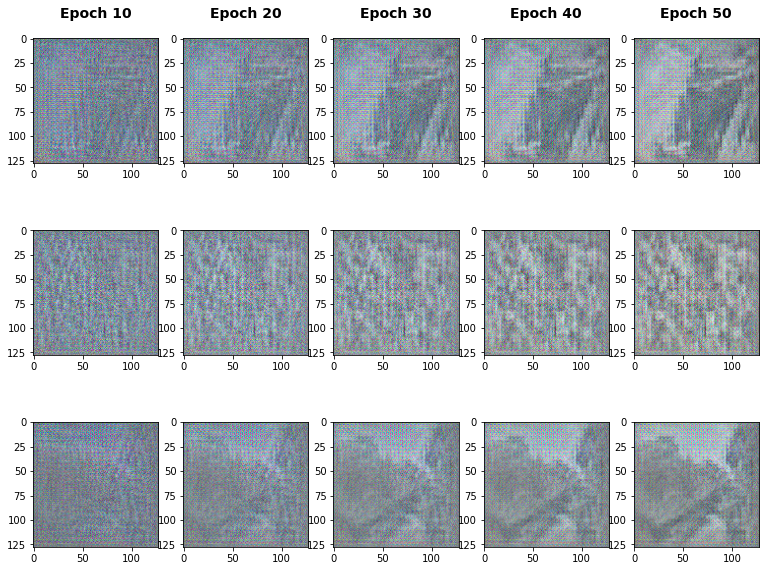

In [ ]:
plot_epochs(3, False)

## More Training

To try and improve the generator's performance, I will train the model further. Also, since the discriminator's loss improved while the generator did not, I will set `adv_learning` to False so that only the generator's weights will be updated.

Restoring weights training checkpoint

In [ ]:
checkpoint.restore(file_loc.format(50))

In [ ]:
adv_learning = False

In [ ]:
for x in range(50):
  train_dataset_mapped = train_ds.map(process_path,num_parallel_calls=tf.data.AUTOTUNE).batch(32)
  val_dataset_mapped = val_ds.map(process_path,num_parallel_calls=tf.data.AUTOTUNE).batch(32)
  for image_batch in tqdm.tqdm(train_dataset_mapped, position=0, leave=True):
    logs=train_step(image_batch,loss_func,adv_learning,evaluate,adv_ratio)
  if (x + 1) % 10 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)
  for k in logs.keys():
    print(k,':',logs[k],end='  ')  
  print('Epoch:', x + 1, "Complete")

100%|██████████| 67/67 [02:37<00:00,  2.35s/it]


reconstruction : tf.Tensor(2.842117, shape=(), dtype=float32)  PSNR : tf.Tensor(8.327377, shape=(), dtype=float32)  Epoch: 1 Complete


100%|██████████| 67/67 [03:21<00:00,  3.01s/it]


reconstruction : tf.Tensor(2.826772, shape=(), dtype=float32)  PSNR : tf.Tensor(8.36786, shape=(), dtype=float32)  Epoch: 2 Complete


100%|██████████| 67/67 [02:28<00:00,  2.21s/it]


reconstruction : tf.Tensor(2.8114882, shape=(), dtype=float32)  PSNR : tf.Tensor(8.40866, shape=(), dtype=float32)  Epoch: 3 Complete


100%|██████████| 67/67 [03:21<00:00,  3.01s/it]


reconstruction : tf.Tensor(2.7962608, shape=(), dtype=float32)  PSNR : tf.Tensor(8.449585, shape=(), dtype=float32)  Epoch: 4 Complete


100%|██████████| 67/67 [03:21<00:00,  3.01s/it]


reconstruction : tf.Tensor(2.7810702, shape=(), dtype=float32)  PSNR : tf.Tensor(8.490795, shape=(), dtype=float32)  Epoch: 5 Complete


100%|██████████| 67/67 [02:30<00:00,  2.24s/it]


reconstruction : tf.Tensor(2.7659678, shape=(), dtype=float32)  PSNR : tf.Tensor(8.531662, shape=(), dtype=float32)  Epoch: 6 Complete


100%|██████████| 67/67 [03:21<00:00,  3.01s/it]


reconstruction : tf.Tensor(2.7509594, shape=(), dtype=float32)  PSNR : tf.Tensor(8.572837, shape=(), dtype=float32)  Epoch: 7 Complete


100%|██████████| 67/67 [03:21<00:00,  3.01s/it]


reconstruction : tf.Tensor(2.7360501, shape=(), dtype=float32)  PSNR : tf.Tensor(8.614119, shape=(), dtype=float32)  Epoch: 8 Complete


100%|██████████| 67/67 [03:21<00:00,  3.01s/it]


reconstruction : tf.Tensor(2.7212863, shape=(), dtype=float32)  PSNR : tf.Tensor(8.655492, shape=(), dtype=float32)  Epoch: 9 Complete


100%|██████████| 67/67 [02:29<00:00,  2.23s/it]


reconstruction : tf.Tensor(2.7066188, shape=(), dtype=float32)  PSNR : tf.Tensor(8.696987, shape=(), dtype=float32)  Epoch: 10 Complete


100%|██████████| 67/67 [03:21<00:00,  3.01s/it]


reconstruction : tf.Tensor(2.6920755, shape=(), dtype=float32)  PSNR : tf.Tensor(8.73817, shape=(), dtype=float32)  Epoch: 11 Complete


100%|██████████| 67/67 [02:28<00:00,  2.22s/it]


reconstruction : tf.Tensor(2.6777081, shape=(), dtype=float32)  PSNR : tf.Tensor(8.7790165, shape=(), dtype=float32)  Epoch: 12 Complete


100%|██████████| 67/67 [02:32<00:00,  2.28s/it]


reconstruction : tf.Tensor(2.6634362, shape=(), dtype=float32)  PSNR : tf.Tensor(8.819837, shape=(), dtype=float32)  Epoch: 13 Complete


100%|██████████| 67/67 [02:43<00:00,  2.44s/it]


reconstruction : tf.Tensor(2.6493366, shape=(), dtype=float32)  PSNR : tf.Tensor(8.860475, shape=(), dtype=float32)  Epoch: 14 Complete


100%|██████████| 67/67 [03:21<00:00,  3.01s/it]


reconstruction : tf.Tensor(2.6354103, shape=(), dtype=float32)  PSNR : tf.Tensor(8.90097, shape=(), dtype=float32)  Epoch: 15 Complete


100%|██████████| 67/67 [03:21<00:00,  3.01s/it]


reconstruction : tf.Tensor(2.6216395, shape=(), dtype=float32)  PSNR : tf.Tensor(8.941257, shape=(), dtype=float32)  Epoch: 16 Complete


100%|██████████| 67/67 [03:21<00:00,  3.01s/it]


reconstruction : tf.Tensor(2.6079848, shape=(), dtype=float32)  PSNR : tf.Tensor(8.981261, shape=(), dtype=float32)  Epoch: 17 Complete


100%|██████████| 67/67 [03:21<00:00,  3.01s/it]


reconstruction : tf.Tensor(2.5945156, shape=(), dtype=float32)  PSNR : tf.Tensor(9.021114, shape=(), dtype=float32)  Epoch: 18 Complete


100%|██████████| 67/67 [02:49<00:00,  2.53s/it]


reconstruction : tf.Tensor(2.581197, shape=(), dtype=float32)  PSNR : tf.Tensor(9.060524, shape=(), dtype=float32)  Epoch: 19 Complete


100%|██████████| 67/67 [03:21<00:00,  3.01s/it]


reconstruction : tf.Tensor(2.5680125, shape=(), dtype=float32)  PSNR : tf.Tensor(9.099827, shape=(), dtype=float32)  Epoch: 20 Complete


100%|██████████| 67/67 [02:31<00:00,  2.25s/it]


reconstruction : tf.Tensor(2.5550401, shape=(), dtype=float32)  PSNR : tf.Tensor(9.138997, shape=(), dtype=float32)  Epoch: 21 Complete


100%|██████████| 67/67 [02:29<00:00,  2.23s/it]


reconstruction : tf.Tensor(2.54222, shape=(), dtype=float32)  PSNR : tf.Tensor(9.17794, shape=(), dtype=float32)  Epoch: 22 Complete


100%|██████████| 67/67 [03:21<00:00,  3.01s/it]


reconstruction : tf.Tensor(2.529642, shape=(), dtype=float32)  PSNR : tf.Tensor(9.216639, shape=(), dtype=float32)  Epoch: 23 Complete


100%|██████████| 67/67 [03:21<00:00,  3.01s/it]


reconstruction : tf.Tensor(2.5173028, shape=(), dtype=float32)  PSNR : tf.Tensor(9.255227, shape=(), dtype=float32)  Epoch: 24 Complete


100%|██████████| 67/67 [02:29<00:00,  2.23s/it]


reconstruction : tf.Tensor(2.5051467, shape=(), dtype=float32)  PSNR : tf.Tensor(9.293591, shape=(), dtype=float32)  Epoch: 25 Complete


100%|██████████| 67/67 [03:21<00:00,  3.01s/it]


reconstruction : tf.Tensor(2.4931564, shape=(), dtype=float32)  PSNR : tf.Tensor(9.331464, shape=(), dtype=float32)  Epoch: 26 Complete


100%|██████████| 67/67 [02:33<00:00,  2.29s/it]


reconstruction : tf.Tensor(2.4813185, shape=(), dtype=float32)  PSNR : tf.Tensor(9.369024, shape=(), dtype=float32)  Epoch: 27 Complete


100%|██████████| 67/67 [03:21<00:00,  3.01s/it]


reconstruction : tf.Tensor(2.469609, shape=(), dtype=float32)  PSNR : tf.Tensor(9.4061775, shape=(), dtype=float32)  Epoch: 28 Complete


100%|██████████| 67/67 [03:21<00:00,  3.01s/it]


reconstruction : tf.Tensor(2.4580963, shape=(), dtype=float32)  PSNR : tf.Tensor(9.442897, shape=(), dtype=float32)  Epoch: 29 Complete


100%|██████████| 67/67 [02:34<00:00,  2.31s/it]


reconstruction : tf.Tensor(2.4468021, shape=(), dtype=float32)  PSNR : tf.Tensor(9.479012, shape=(), dtype=float32)  Epoch: 30 Complete


100%|██████████| 67/67 [02:34<00:00,  2.30s/it]


reconstruction : tf.Tensor(2.4356987, shape=(), dtype=float32)  PSNR : tf.Tensor(9.514448, shape=(), dtype=float32)  Epoch: 31 Complete


100%|██████████| 67/67 [02:28<00:00,  2.22s/it]


reconstruction : tf.Tensor(2.4247491, shape=(), dtype=float32)  PSNR : tf.Tensor(9.549386, shape=(), dtype=float32)  Epoch: 32 Complete


100%|██████████| 67/67 [02:27<00:00,  2.20s/it]


reconstruction : tf.Tensor(2.4139602, shape=(), dtype=float32)  PSNR : tf.Tensor(9.58388, shape=(), dtype=float32)  Epoch: 33 Complete


100%|██████████| 67/67 [02:27<00:00,  2.19s/it]


reconstruction : tf.Tensor(2.4033754, shape=(), dtype=float32)  PSNR : tf.Tensor(9.617672, shape=(), dtype=float32)  Epoch: 34 Complete


100%|██████████| 67/67 [03:21<00:00,  3.01s/it]


reconstruction : tf.Tensor(2.3930466, shape=(), dtype=float32)  PSNR : tf.Tensor(9.650816, shape=(), dtype=float32)  Epoch: 35 Complete


100%|██████████| 67/67 [02:28<00:00,  2.22s/it]


reconstruction : tf.Tensor(2.3829286, shape=(), dtype=float32)  PSNR : tf.Tensor(9.683503, shape=(), dtype=float32)  Epoch: 36 Complete


100%|██████████| 67/67 [03:21<00:00,  3.01s/it]


reconstruction : tf.Tensor(2.3729699, shape=(), dtype=float32)  PSNR : tf.Tensor(9.715572, shape=(), dtype=float32)  Epoch: 37 Complete


100%|██████████| 67/67 [03:21<00:00,  3.01s/it]


reconstruction : tf.Tensor(2.3633149, shape=(), dtype=float32)  PSNR : tf.Tensor(9.7469845, shape=(), dtype=float32)  Epoch: 38 Complete


100%|██████████| 67/67 [02:44<00:00,  2.46s/it]


reconstruction : tf.Tensor(2.3539224, shape=(), dtype=float32)  PSNR : tf.Tensor(9.777532, shape=(), dtype=float32)  Epoch: 39 Complete


100%|██████████| 67/67 [02:35<00:00,  2.33s/it]


reconstruction : tf.Tensor(2.3447416, shape=(), dtype=float32)  PSNR : tf.Tensor(9.807057, shape=(), dtype=float32)  Epoch: 40 Complete


100%|██████████| 67/67 [03:21<00:00,  3.01s/it]


reconstruction : tf.Tensor(2.33573, shape=(), dtype=float32)  PSNR : tf.Tensor(9.835818, shape=(), dtype=float32)  Epoch: 41 Complete


100%|██████████| 67/67 [03:21<00:00,  3.01s/it]


reconstruction : tf.Tensor(2.326886, shape=(), dtype=float32)  PSNR : tf.Tensor(9.863783, shape=(), dtype=float32)  Epoch: 42 Complete


100%|██████████| 67/67 [03:21<00:00,  3.01s/it]


reconstruction : tf.Tensor(2.3182724, shape=(), dtype=float32)  PSNR : tf.Tensor(9.890953, shape=(), dtype=float32)  Epoch: 43 Complete


100%|██████████| 67/67 [02:30<00:00,  2.24s/it]


reconstruction : tf.Tensor(2.3098502, shape=(), dtype=float32)  PSNR : tf.Tensor(9.917433, shape=(), dtype=float32)  Epoch: 44 Complete


100%|██████████| 67/67 [03:21<00:00,  3.01s/it]


reconstruction : tf.Tensor(2.3016157, shape=(), dtype=float32)  PSNR : tf.Tensor(9.943109, shape=(), dtype=float32)  Epoch: 45 Complete


100%|██████████| 67/67 [02:30<00:00,  2.24s/it]


reconstruction : tf.Tensor(2.2935448, shape=(), dtype=float32)  PSNR : tf.Tensor(9.96788, shape=(), dtype=float32)  Epoch: 46 Complete


100%|██████████| 67/67 [02:28<00:00,  2.22s/it]


reconstruction : tf.Tensor(2.2856271, shape=(), dtype=float32)  PSNR : tf.Tensor(9.991885, shape=(), dtype=float32)  Epoch: 47 Complete


100%|██████████| 67/67 [03:21<00:00,  3.01s/it]


reconstruction : tf.Tensor(2.2778733, shape=(), dtype=float32)  PSNR : tf.Tensor(10.015176, shape=(), dtype=float32)  Epoch: 48 Complete


100%|██████████| 67/67 [03:21<00:00,  3.01s/it]


reconstruction : tf.Tensor(2.2703094, shape=(), dtype=float32)  PSNR : tf.Tensor(10.037717, shape=(), dtype=float32)  Epoch: 49 Complete


100%|██████████| 67/67 [02:38<00:00,  2.36s/it]


reconstruction : tf.Tensor(2.262936, shape=(), dtype=float32)  PSNR : tf.Tensor(10.059363, shape=(), dtype=float32)  Epoch: 50 Complete


Here we see consistent, albeit small, improvements in the generator's performance after almost every epoch.

Looking at the model's predictions on the test data, we can see that further training definitely improved the model's predictions. The colors appear to match more accurately, although there is definitely still some random noise.

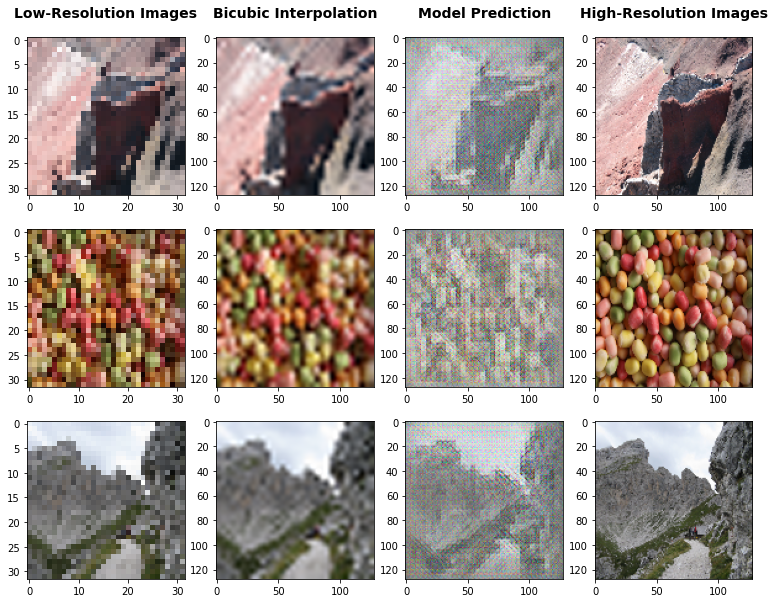

In [ ]:
plot_predictions(3, clip=False)

## Summary

Overall I found my first time training GANs to be fairly challenging as training two networks at once adds complexity. I think the images eventually would have become more photo-realistic if I could have trained them longer. With every epoch, the images improved, and I think they could have reached a point where they were photo-realistic. However, it took about 7 hours to train this model, and I imagine it could be a lot longer before they look truly photo-realistic.

The results from my SRGAN can also be used as a benchmark to compare other models, such as the ESRGAN. SRGAN was an early model for photo-realistic image generation, and more models have since been created with better performance.